# DSCI 100: Group 20 Project Proposal

**Date**: *July 30th, 2021*

**Authors**: *Thomas Cowan, Marcela Flaherty, Tony Liang, Hamidreza Yarveicy*

### Import necessary packages
httr, ggplot2, and GGally were all available without installation on the DSCI 100 Jupyter Hub, but if errors occur, please install these packages.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Introduction

Pulsars are defined as a type of Neutron stars that produce radio emissions distinguishable on Earth. Limited research has been conducted on the detection of pulsars with the use of data science methods. To advance the work of other researchers in studying pulsars (Simth,1977$^{[1]}$), we will attempt to answer the following question: 

> Can pulsar radio emissions be accurately differentiated from radio frequency interference and radio noise?

To address this question properly, we will investigate a collection of radio emissions recorded during the [High Time Resolution Universe Pulsar Survey](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip)$^{[2]}$ (HTRU2). It contains 16,259 spurious examples (i.e., radio interference or noise) and 1,639 real pulsar examples.

The HTRU2 data set contains statistics on signal-to-noise ratios (SNR) and integrated profiles (a method of stacking multiple measurements of the same pulsar) of areas of The Southern Hemisphere. An artist's animation (top) of a radio profile from a pulsar, and a series of these profiles from a single star integrated together (bottom) is show below.


<img src="./media/pulsar_animation_astronl.gif" width="250" align="center">
<img src="./media/pulse_stack.gif" width="250" align="center">

[Joeri van Leeuwen. License: CC-BY-AS](https://www.astron.nl/pulsars/animations/)

[Essentials of Radio Astronomy](https://www.cv.nrao.edu/~sransom/web/Ch6.html)

## Preliminary Exploratory Data Analysis

#### Download Pulsar Data

In [2]:
# Download Pulsar data without kaggle helpers
PULSAR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(PULSAR_URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it, renaming the columns as below
# then mutate the target class to a meaningful value for a human and convert to a factor
pulsar_data_raw <- read_csv(unz(tf, "HTRU_2.csv"), col_names = c("mean_ip", 
                                                             "std_ip", 
                                                             "excess_kurtosis_ip", 
                                                             "skewness_ip", 
                                                             "mean_dm_snr", 
                                                             "std_dm_snr", 
                                                             "excess_kurtosis_dm_snr", 
                                                             "skewness_dm_snr", 
                                                             "target_class")) %>% 
                 mutate(target_class = as_factor(case_when(
                                                target_class == 1 ~ "pulsar",
                                                TRUE ~ "rf_noise")))  
# unlink/remove the temporary file
unlink(tf)

# preview the data
pulsar_data_raw %>% head(5)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2021-07-29 00:50
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpXpJ4U5/file18b3159a44.zipNULL

Parsed with column specification:
cols(
  mean_ip = col_double(),
  std_ip = col_double(),
  excess_kurtosis_ip = col_double(),
  skewness_ip = col_double(),
  mean_dm_snr = col_double(),
  std_dm_snr = col_double(),
  excess_kurtosis_dm_snr = col_double(),
  skewness_dm_snr = col_double(),
  target_class = col_double()
)



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rf_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rf_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rf_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rf_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rf_noise


### Raw data summary
This data is already tidy.

We have elected to use a high training proportion split of 80/20 train/test. This reasoning is discussed in the methods section. 

In [3]:
set.seed(1) # set the random seed so that sample_frac selects the same rows each run
pulsar_split <- initial_split(pulsar_data_raw, prop = 0.8, strata = target_class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

pulsar_data_split_label <- full_join(pulsar_train %>% mutate(is_training = TRUE), 
                                     pulsar_test %>% mutate(is_training = FALSE)
                                    )
pulsar_data_split_label %>% head(5)

Joining, by = c("mean_ip", "std_ip", "excess_kurtosis_ip", "skewness_ip", "mean_dm_snr", "std_dm_snr", "excess_kurtosis_dm_snr", "skewness_dm_snr", "target_class", "is_training")



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class,is_training
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rf_noise,TRUE
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rf_noise,TRUE
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rf_noise,TRUE
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rf_noise,TRUE
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rf_noise,TRUE


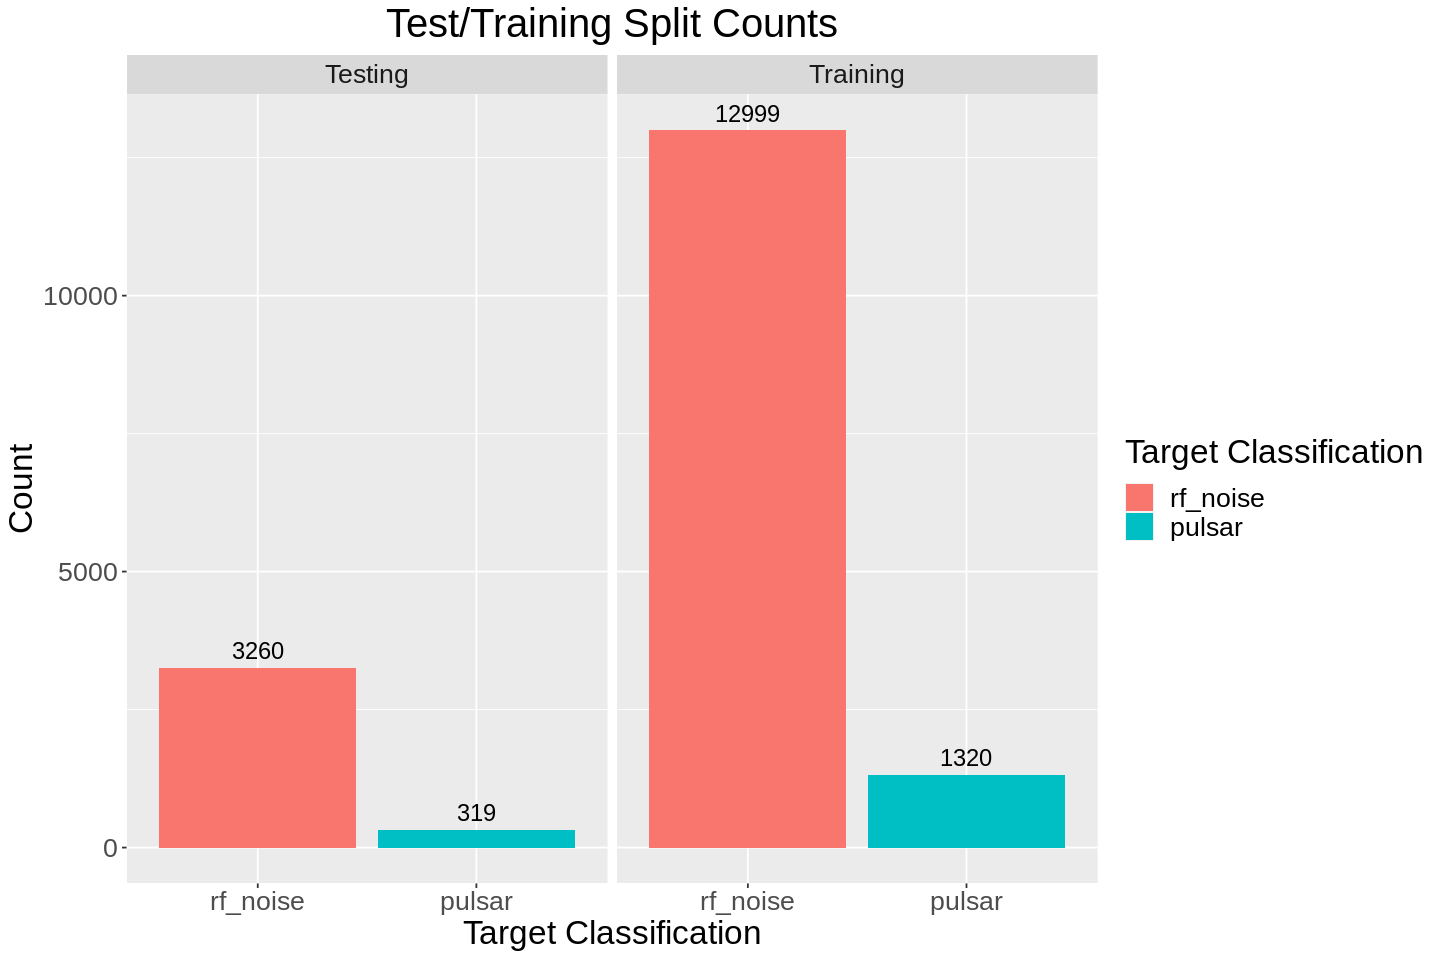

In [4]:
options(repr.plot.width = 12, repr.plot.height = 8)
training_bar_plot <- pulsar_data_split_label %>% 
                        ggplot(aes(x = target_class, fill = target_class)) + 
                            geom_bar() +
                            labs(x = "Target Classification", 
                                 y = "Count",
                                 fill = "Target Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -0.5, size=5) +
                            ggtitle("Test/Training Split Counts") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                        facet_wrap(~ is_training,
                                   labeller = labeller(is_training = c("TRUE" = "Training", "FALSE" = "Testing")))
training_bar_plot

#### Summary stats of the unscaled pulsar data
The following table summarizes the max, min, mean, variance, and standard deviation, and number of NaNs for each predictor variable for the unscaled pulsar data.

In [5]:
min_df <- pulsar_train %>% 
            select(-target_class) %>% 
            map_df(min)
max_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(max)
mean_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(mean)
sd_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(sd)
var_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(var)
count_nan_df <- pulsar_train %>% 
                select(-target_class) %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(pulsar_train %>% select(-target_class))

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type)

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,6.179688,24.79161,-1.8760112,-1.781888,0.2132107,7.370432,-3.139270,-1.976976
max,192.617188,98.77891,8.0695220,68.101622,223.3921405,110.642211,34.539844,1191.000837
mean,110.972156,46.52927,0.4820007,1.784217,12.6559686,26.340176,8.308947,105.114844
var,662.587788,46.77671,1.1426912,38.343692,873.1172361,378.778683,20.456181,11543.479013
st_dev,25.740781,6.83935,1.0689674,6.192228,29.5485573,19.462237,4.522851,107.440584
nan_count,0.000000,0.00000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000


#### Processing Recipe (used in scaled pair plots)

In [6]:
pulsar_recipe <- recipe(target_class ~ mean_ip + std_ip + excess_kurtosis_ip + skewness_ip + std_dm_snr, data = pulsar_train) %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors())

# for visualizing excluded variables
pulsar_recipe_all <- recipe(target_class ~ mean_ip + std_ip + excess_kurtosis_ip + skewness_ip +
                                           mean_dm_snr + std_dm_snr + excess_kurtosis_dm_snr + skewness_dm_snr, 
                                           data = pulsar_train) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors())

pulsar_scaled <- pulsar_recipe %>% 
                    prep() %>% 
                    bake(pulsar_train)
# for visualizing excluded variables
pulsar_scaled_all <- pulsar_recipe_all %>% 
                    prep() %>% 
                    bake(pulsar_train)

pulsar_scaled %>%  head(5)


mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,std_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1495512,1.3385054,-0.67034052,-0.4011262,-0.3714758,rf_noise
-0.3288301,1.8061884,-0.01560625,-0.3713211,-0.5898618,rf_noise
-0.3091022,-1.0509223,-0.14843517,-0.1183827,-0.2361243,rf_noise
1.0014399,1.5570447,-0.51490381,-0.3908860,-0.2764788,rf_noise
-0.8642159,-0.8563751,0.11119643,-0.1067023,-0.7641185,rf_noise


#### Exploratory Plotting
The pair plot below highlights the relationships and distributions of the five chosen variables which will be used as predictors of the target class.

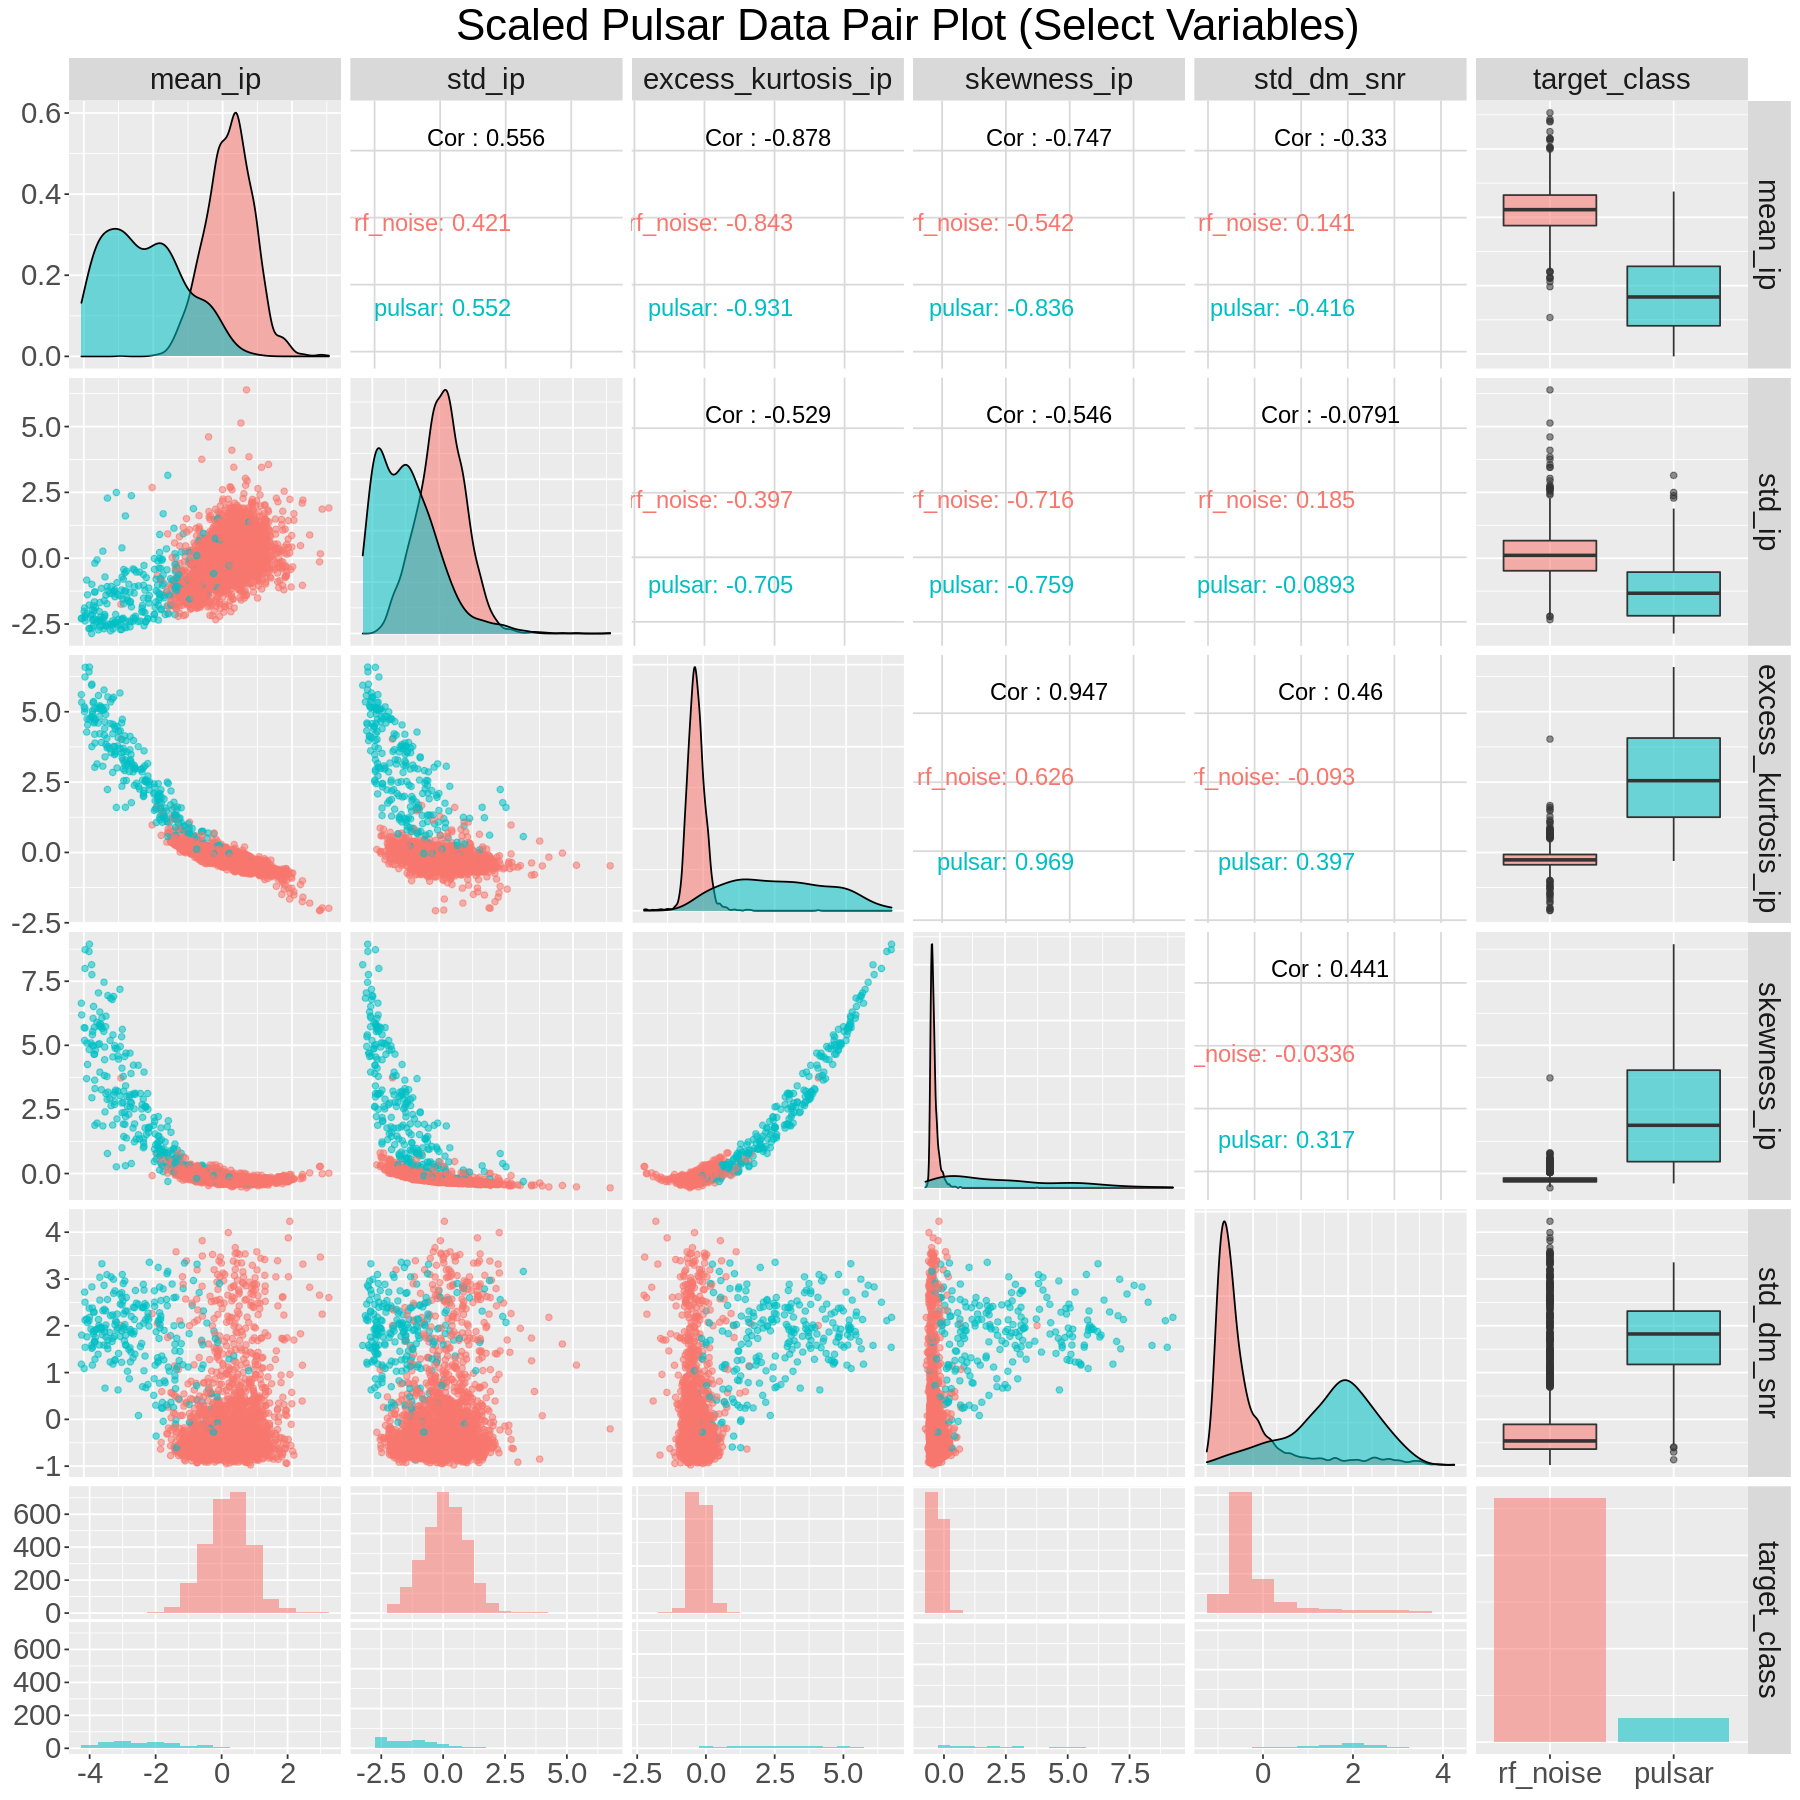

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15)

# subset of the data for faster plotting
pulsar_scaled_subset <- pulsar_scaled %>% sample_frac(0.2) 

ggpairs(pulsar_scaled_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot (Select Variables)") +
        theme(text = element_text(size = 22),
              plot.title = element_text(hjust = 0.5))
        

# Methods 

This is a classification problem, and we will make use of a KNN model for our predictions, tuned using the v-fold cross-validation methods we learned in worksheet 7.

The HTRU2 data set has several thousand entries (17,898), and there is considerable overlap between pulsars and radio noise in many of the provided variables. 80% of our data will be reserved for training, as we believe our model will require a significant proportion of our data to distinguish between classes in these overlapping zones.

We will exclude "mean_dm_snr", "excess_kurtosis_dm_snr", and "skewness_dm_snr" from our model as these variables do not provide good separation when plotted against the other available data. Plots of two of these exlcuded variables are below. 

Among other plots, we will use scatter plots colored by correct/incorrect predictions to visualize the areas the model struggles. We will also focus on colorblind-friendly palettes. 


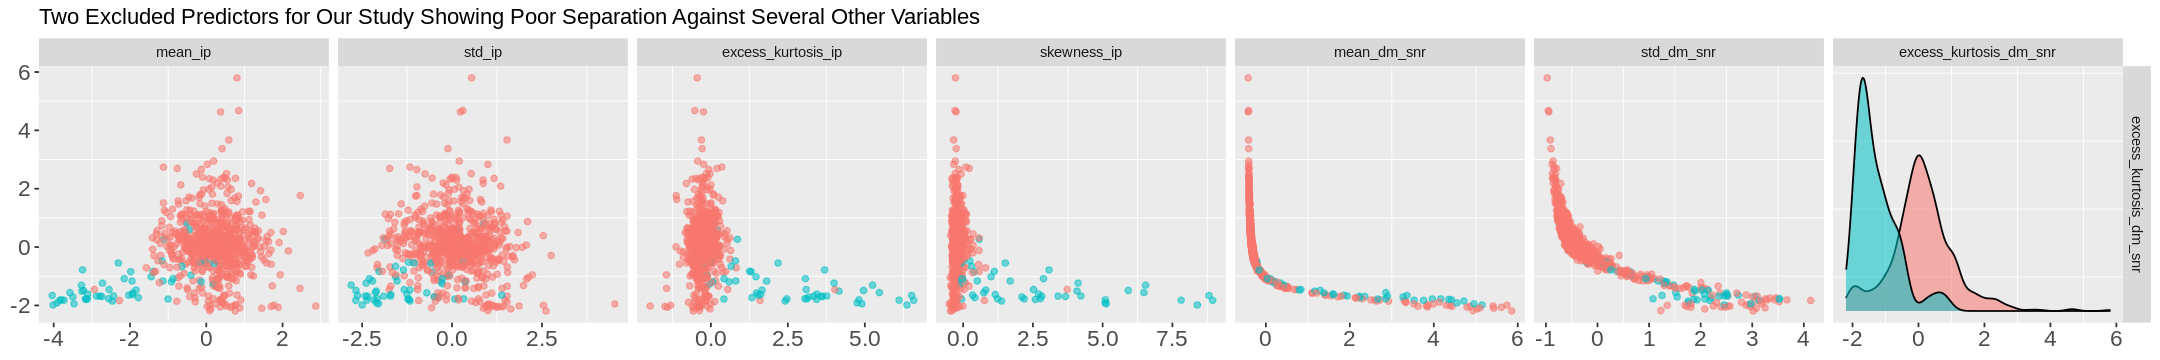

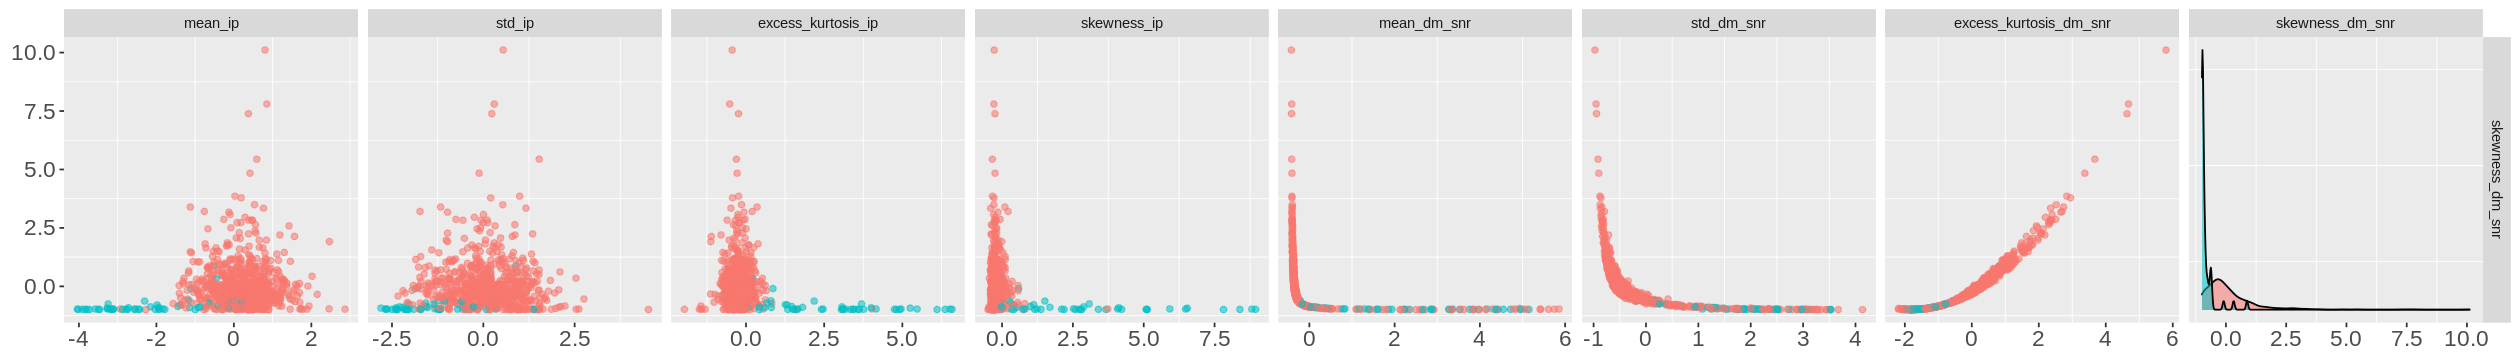

In [9]:
# generate the pairs plot for all variables
pairs_plot <- ggpairs(pulsar_scaled_all %>% sample_frac(0.05),
                   legend = 1,
                   mapping = aes(color=target_class,  alpha=0.5),
                   lower=list(combo=wrap("facethist", binwidth=0.5),
                             discrete = "blank", combo="blank"),
                   upper=list(continuous = wrap("cor", size=5, alignPercent=0.85))) +
                ggtitle("Scaled Pulsar Data Pair Plot All: Pulsars (Blue), Radio Noise (Red)") +
                theme(text = element_text(size = 17),
                      plot.title = element_text(hjust = 0.5),
                      legend.position = "bottom",
                      panel.grid.major = element_blank())

skewness_dm_snr_plots <- lapply(1:pairs_plot$ncol, function(j) getPlot(pairs_plot, i = 8, j = j))
excess_kurtosis_dm_snr_plots <- lapply(1:pairs_plot$ncol, function(j) getPlot(pairs_plot, i = 7, j = j))

# set unwanted elements to NULL
skewness_dm_snr_plots[9] <- NULL 
excess_kurtosis_dm_snr_plots[8:9] <- NULL

# Plot the two unused variables excess_kurtosis_dm_snr, skewness_dm_snr
options(repr.plot.width = 18, repr.plot.height = 3)
ggmatrix(
    excess_kurtosis_dm_snr_plots,
    nrow=1,
    ncol = pairs_plot$ncol,
    xAxisLabels = pairs_plot$xAxisLabels[1:7],
    yAxisLabels = pairs_plot$yAxisLabels[7],
    title = "Two Excluded Predictors for Our Study Showing Poor Separation Against Several Other Variables"
)
options(repr.plot.width = 21, repr.plot.height = 3)
ggmatrix(
    skewness_dm_snr_plots,
    nrow=1,
    ncol = pairs_plot$ncol,
    xAxisLabels = pairs_plot$xAxisLabels[1:8],
    yAxisLabels = pairs_plot$yAxisLabels[8]
)


# Expectated Outcomes and Significance
We expect to be able to distinguish between a pulsar star and all other observed stars using statistical predictors.

### Impact of Findings
Pulsars allow us to study extreme states of matter, investigate beyond our solar system, and measure interstellar distances$^{[3]}$. Information gleaned from studying pulsars has broad applicability, and rapid, efficient, and accurate delineation of the pulsar start/radio noise boundary is scientifically significant.

### Future Questions
One of the most significant impacts of pulsar analysis is the study of space-time, this is because of the pulse, or blinking, that occurs with a pulsar. Through this natural clock, we can use pulsars when asking questions about distance and time between objects in space$^{[4]}$.


# Citations
$^{[1]}$Smith, F. G. (1977). Pulsars. *Cambridge Monographs on Physics*

$^{[2]}$R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, *Fifty Years of Pulsar
		Candidate Selection: From simple filters to a new principled real-time classification approach
		MNRAS*, 2016.

$^{[3]}$Cofield, C. (2016, April 22). *What are pulsars?* Space.com. https://www.space.com/32661-pulsars.html.*

$^{[4]}$NASA. (2011, January). *Pulsars*. NASA. https://imagine.gsfc.nasa.gov/science/objects/pulsars2.html.old.